In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

In [2]:
def calibrate():
    pathToImages = 'camera_cal/'
    calFiles = [f for f in os.listdir(pathToImages) if os.path.isfile(pathToImages.join(f))]
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # prepare object points
    nx = 9
    ny = 6
    
    objpoints = []
    imgpoints = []
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Make a list of calibration images
    for image in images:
        img = mpimg.imread(image)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            # Draw and display the corners
#             cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#             plt.imshow(img)
#             plt.show()
            imgpoints.append(corners)
            objpoints.append(objp)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist


In [3]:
mtx, dist = calibrate()

In [4]:
def getThresholdedSobel(undist, orient='x', thresh_min=20, thresh_max=100):
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    else:
        return None
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

In [5]:
def mag_thresh(undist, sobel_kernel=3, mag_thresh=(100, 200)):
    # Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
def getGradientImgCombined(undist):
    ksize = 3

    gradx = getThresholdedSobel(undist, orient='x')
    grady = getThresholdedSobel(undist, orient='y')

    # plt.imshow(sobelx, cmap='gray')
    # plt.show()
    # plt.imshow(sobely, cmap='gray')
    # plt.show()

    magn = mag_thresh(undist)
    direction = dir_threshold(undist, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(direction)
    combined[((gradx == 1) & (grady == 1)) | ((magn == 1) & (direction == 1))] = 1
    return combined

In [8]:
def getColorCombined(undist, 
                     gray_thresh=(180, 255), 
                     r_thresh=(230, 255)):
#     gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
#     gray_binary = np.zeros_like(gray)
#     gray_binary[(gray > gray_thresh[0]) & (gray <= gray_thresh[1])] = 1
    
    R = undist[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (90, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    combined = np.zeros_like(r_binary)
#     combined[((gray_binary == 1) | (r_binary == 1))] = 1
#     combined[((r_binary == 1) & (s_binary == 1))] = 1
    combined[((s_binary == 1))] = 1
#     combined[((r_binary == 1))] = 1
    
    return combined

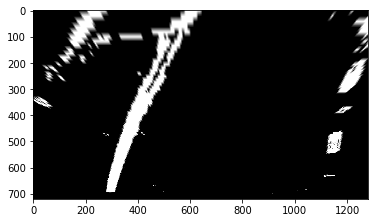

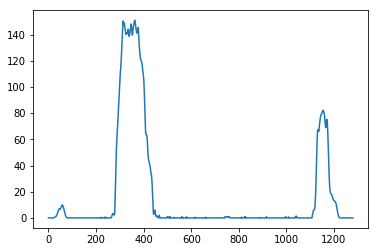

In [100]:
def getBinaryWarped(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([(590, 450), (690, 450), (1060, 690), (250, 690)])
    dst = np.float32([(250, 0), (1060, 0), (1060, 690), (250, 690)])

#     plt.imshow(img, cmap='gray')
#     for point in src:
#         plt.plot(point[0], point[1], '.')
#     plt.show()
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
#     plt.imshow(warped, cmap='gray')
#     for point in dst:
#         plt.plot(point[0], point[1], '.')
#     plt.show()
    
    return warped, Minv

# img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test6.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
# plt.imshow(undist)
# plt.show()

grad_combined = getGradientImgCombined(undist)
# plt.imshow(grad_combined, cmap='gray')
# plt.show()

color_combined = getColorCombined(undist, gray_thresh=(190, 255), r_thresh=(210, 255))

# Combine the two binary thresholds
combined_binary = np.zeros_like(grad_combined)
combined_binary[(grad_combined == 1) | (color_combined == 1)] = 1

# plt.imshow(combined_binary, cmap='gray')
# plt.show()

binary_warped, Minv = getBinaryWarped(combined_binary)
plt.imshow(binary_warped, cmap='gray')
plt.show()

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [101]:
# Create an output image to draw on and  visualize the result
out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')

# plt.imshow(out_img, cmap='gray')
# plt.show()

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)

# TODO: use several points
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# plt.imshow(out_img)
# plt.show()

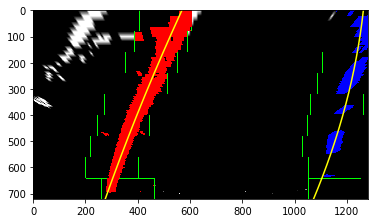

In [102]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [103]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

2296.53324225 m 775.763039183 m


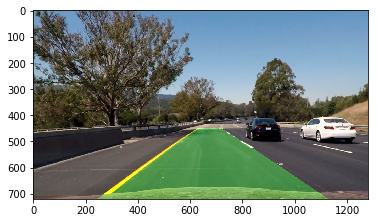

In [104]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()